<a href="https://colab.research.google.com/github/kyun99/TaskStream/blob/master/Plebs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To initialise

In [ ]:
!pip install tensorflow-text
!pip install maltiverse

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 462 kB 48.4 MB/s 
  Created wheel for maltiverse: filename=maltiverse-1.0.0-py3-none-any.whl size=4906 sha256=2b2b131fb60e1dbe1a14f45528b8931c496d7a8081bf8fce8bd4933d524b6e01
  Stored in directory: /root/.cache/pip/wheels/51/1b/86/28ecd5e89b517432ab302118dbef016b0000c20dba6c42ca61
Successfully built maltiverse


In [ ]:
!pip freeze > kaggle_image_requirements.txt

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import smtplib
import imaplib
import email
import nltk
import requests
from bs4 import BeautifulSoup
from maltiverse import Maltiverse
import json
import time
import random
import matplotlib.pyplot as plt
from email.message import EmailMessage
import secretKeys
from tensorflow import keras


In [5]:
def get_body(msg):
    if msg.is_multipart():
        return get_body(msg.get_payload(0))
    else:
        return msg.get_payload(None,True)

In [6]:
def response(verdict, raw, user, user_pass):
  msg = EmailMessage()
  msg.set_content("The message sent is rated to be " + verdict)

  msg['Subject'] = 'Suspicious email rating'
  msg['From'] = user
  msg['To'] =  [raw["from"]]
  server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
  server.login(user, user_pass)
  server.send_message(msg)
  server.close()

In [7]:
# Params for bert model and tokenization
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

In [8]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        try:
            tokens = row.split(" ")[:maxtokens]
        except:
            tokens=""
    return tokens

In [9]:
def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    
print(stopwords) # see default stopwords

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [12]:
emails = pd.read_csv("/content/emails.csv", engine="python", error_bad_lines=False)

print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 18226: field larger than field limit (131072)
Skipping line 20082: ',' expected after '"'


Successfully loaded 25747 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


Skipping line 25762: unexpected end of data
Skipping line 20098: Expected 2 fields in line 20098, saw 5
Skipping line 20099: Expected 2 fields in line 20099, saw 5


In [13]:
def extract_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages

bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [14]:
bodies_df = pd.DataFrame(random.sample(bodies, 10000))

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

bodies_df.head() # you could do print(bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

,0
0,we had said we were going to vote on trades. we have had our first trade. \nsome people have come to me requesting a vote\n\n\nplease go to the website and vote on the trade between the the Lie Downs and \nthe Rounders
1,"November 21, 2000\n\n\nThis week's Click 'n Save Email Update is a\nreminder of the great $99/$109 or less each way\nCoast-to-Coast southwest.com Only Specials\n\nYour Invitation to e-Freedom still stands.\nGobble It Up!\n\n********* southwest.com e-Freedom Sale *********\n\nWho: southwest.com C..."
2,Assigned to: CN=Jeff Arnold/OU=GCO/O=Enron\nUpdated by: CN=Jeff Arnold/OU=GCO/O=Enron
3,"In my new role as social secretary for James, I wanted to let you know that \nhe will be in London next week on business. He will arrive on Monday morning \n(February 5) and should be in the Enron office most of the day on Monday, \nTuesday and Wednesday. He will fly back to Houston on Thursd..."
4,"FYI...The daily numbers for 2000 do not include middle market orig. For 2001, they are inclusive of middle market orig."


In [24]:
filepath = "/content/fradulent_emails.txt"
with open(filepath, 'r',encoding="latin1") as file:
    data = file.read()
    
# split on a code word appearing close to the beginning of each email
fraud_emails = data.split("From r")

print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


In [25]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails,columns=["message"],dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:])

fraud_bodies_df.head() # you could do print(fraud_bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

Successfully retrieved message body from e-mails!


,0
0,"FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-27-587908.\nE-MAIL: (james_ngola2002@maktoob.com).\n\nURGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\n\nDEAR FRIEND,\n\nI AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY G..."
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom officer and work as Assistant controller of the Customs and Excise department Of the Federal Ministry of Internal Affairs stationed at the Murtala Mohammed International Airport, Ikeja, Lagos-Nigeria.\n\nAfter the sudden death of the former Head of s..."
2,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
3,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
4,"Dear sir, \n \nIt is with a heart full of hope that I write to seek your help in respect of the context below. I am Mrs. Maryam Abacha the former first lady of the former Military Head of State of Nigeria General Sani Abacha whose sudden death occurred on 8th of June 1998 as a result of cardiac ..."


In [26]:
EnronEmails = bodies_df.iloc[:,0].apply(tokenize)
EnronEmails = EnronEmails.apply(stop_word_removal)
EnronEmails = EnronEmails.apply(reg_expressions)
EnronEmails = EnronEmails.sample(Nsamp)

SpamEmails = fraud_bodies_df.iloc[:,0].apply(tokenize)
SpamEmails = SpamEmails.apply(stop_word_removal)
SpamEmails = SpamEmails.apply(reg_expressions)
SpamEmails = SpamEmails.sample(Nsamp)

raw_data = pd.concat([SpamEmails,EnronEmails], axis=0).values

In [27]:
print("Shape of combined data represented as numpy array is:")
print(raw_data.shape)
print("Data represented as numpy array is:")
print(raw_data)

# corresponding labels
Categories = ['spam','notspam']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Shape of combined data represented as numpy array is:
(2000,)
Data represented as numpy array is:
[list(['', 'tayo', 'rimimedinadakar', 'senegal', 'my', 'dear', 'friend', 'compliments', 'of', 'seasoni', 'like', 'send', 'best', 'wishes', 'good', 'health', 'and', 'success', 'pursuits', 'particularly', 'proposal', 'contained', 'letter', 'may', 'wish', 'disclose', 'i', 'got', 'email', 'address', 'now', 'after', 'due', 'deliberation', 'soni', 'decided', 'forward', 'business', 'proposal', 'want', 'assist', 'us', 'i', 'give', 'information', 'as', 'regard', 'soon', 'replyi', 'am', 'mrs', 'rita', 'diatta', '', 'i', 'contacting', 'hope', 'be', 'great', 'assistance', 'meyour', 'urgent', 'response', 'neededregards', 'and', 'god', 'bless', 'youmrsrita', 'diatta'])
 list(['confidentialdear', 'siri', 'franck', 'camara', 'son', 'late', 'former', 'director', 'financemrcamara', 'kingston', 'sierraleone', 'diamond', 'mining', 'corporation', 'i', 'must', 'confessmy', 'agitation', 'real', 'words', 'bond', 

In [28]:
# function for shuffling data in unison with labels/header
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = a[p]
    header = np.asarray(b)[p]
    return data, header

# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
        #print(i)
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    
    return converted_data, np.array(labels)

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])
# 70% of data for training
train_x, train_y = convert_data(raw_data[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(raw_data[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[['froma barrister jim douglaseattorneysflegal practitioner dakar senegal dear friendccompliments daye grace peace lovefrom part atlantice dear friendci barrister jim douglasc solicitor advocatec personal attorney late mre neil frazer national francec used private contractor shell petroleum development company senegalc herein shall referred cliente on st of april c wife three children involved in auto crashc occupants vehicle unfortunately lost livesesince thenc i made several enquiries countrys embassies to locate clients extended relativesa this proved unsuccessfule after several unsuccessful attemptsc i decided contact you business partnership proposale i contacted assist repatriating huge amount money left behind client before get confiscated declared unserviceable financefsecurity company huge deposit lodgede the deceased deposit valued presently million us dollars company issued notice provide next kin benef

In [30]:
def build_model(max_seq_length):
    # tf hub bert model path
    bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" 

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    
    
    preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(bert_path,trainable=False)
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]      # [batch_size, 768].
    sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].# just extract BERT features
    
    # train dense classification layer on top of extracted pooled output features
    dense = tf.keras.layers.Dense(256, activation="relu")(pooled_output)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.Model(inputs=text_input, outputs=pred)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

    return model

In [34]:
model = build_model(maxtokens)


TRAINING = True
if TRAINING:
  history = model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=5,batch_size=32)
  # model.save("my_model")
else:
  keras.models.load_model("my_model")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_3 (KerasLayer)     {'input_mask': (Non  0           ['input_3[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

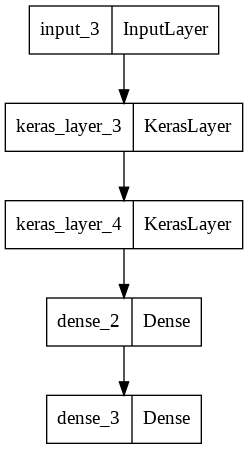

In [35]:
tf.keras.utils.plot_model(model)

In [42]:
def rating2(raw, api_key):
  body = str(get_body(raw))
  links = checkLinks(api_key,body)
  latest = pd.DataFrame([body])
  latest = latest.iloc[:,0].apply(tokenize)
  latest = latest.apply(stop_word_removal)
  latest = latest.apply(reg_expressions)
  latest = latest.sample(Nsamp)
  proba = model.predict(latest)[0]
  print(proba)
  proba =  links*0.45 + proba*0.55
  if proba <0.4:
    return "Not suspicious."
  elif proba >0.6:
    return "Highly suspicious."
  else:
    return "Might be suspicious"

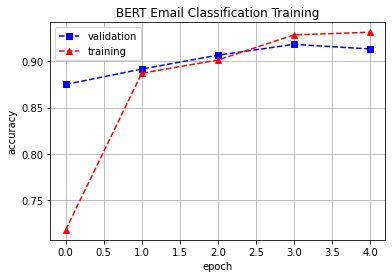

In [37]:

df_history = pd.DataFrame(history.history)
fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_accuracy'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['accuracy'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('BERT Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()

fig.savefig('BERTConvergence.eps', format='eps')
fig.savefig('BERTConvergence.pdf', format='pdf')
fig.savefig('BERTConvergence.png', format='png')
fig.savefig('BERTConvergence.svg', format='svg')

In [38]:
def checkLinks(api_key, body):
  result = re.findall(r"https?://.*", body)
  api = Maltiverse(auth_token=api_key)
  links = []
  for link in result:
    end = 0
    start = 8
    for i in range(start, len(link) - 3):
      if result[0][i:i+3] == "com":
        end = i+3
        break
    links.append(link[start:end])
  links = list(set(links))
  shady = 0
  for i in links:
    result = api.hostname_get("img.mailinblue.com")["classification"]
    if result == "malicious":
      shady = 1 
      break
    elif result == "suspicious" and shady !=1:
      shady = 0.8
  return shady


In [39]:
def rating(raw, api_key):
  body = str(get_body(raw))
  links = checkLinks(api_key,body)
  latest = [body]
  proba = model.predict(latest)[0]
  print(proba)
  proba =  links*0.45 + proba*0.55
  if proba <0.4:
    return "Not suspicious."
  elif proba >0.6:
    return "Highly suspicious."
  else:
    return "Might be suspicious"
  


# To loop

In [ ]:
cur = 16
while(True):
  imap = imaplib.IMAP4_SSL(secretKeys.imap_host)
  imap.login(secretKeys.imap_user, secretKeys.imap_pass)
  imap.select('Inbox')
  tmp, data = imap.search(None, 'ALL')
  inbox = data[0].split()
  if len(inbox) != cur:
    tmp, data = imap.fetch(inbox[cur], '(RFC822)')
    raw = email.message_from_bytes(data[0][1])	
    body = get_body(raw)
    verdict = rating(raw, secretKeys.api_key)
    response(verdict, raw, secretKeys.user, secretKeys.user_pass)
    cur +=1
  time.sleep(60)
  imap.close()

[0.50200796]
[0.3486635]
[0.8418405]
[0.8418405]
[0.11906041]


In [ ]:
files.download('/content/my_model')

In [ ]:
from google.colab import files
!zip -r /content/file.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/assets/vocab.txt (deflated 53%)
  adding: content/my_model/keras_metadata.pb (deflated 85%)
  adding: content/my_model/saved_model.pb (deflated 92%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.index (deflated 79%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 8%)


In [ ]:
files.download('/content/file.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>